# AIR QUALITY

<font size="+3"><strong>1.1. Linear Regression with Time Series Data</strong></font>

In [20]:
import pandas as pd
from data import OpenmeteoAPI, SQLRespository
import sqlite3
from config import settings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import plotly.express as px


## Prepare Data

### API CALL

For the purpose of this project, i will be getting my PM2.5 data using [Open Metro](https://open-meteo.com/) Api. I have created a module to handle that.

In [21]:
# open_api = OpenmeteoAPI()
# record = open_api.getPM2_5(lat=7.403546223182103, lon=3.932032049519837, start_date="2024-01-01", end_date="2024-12-18")
# record

In [22]:
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False)
repo = SQLRespository(connection=connection)

NameError: name 'sqlite3' is not defined

In [23]:
# repo.insert_table(table_name="PM2_5", records=record)

In [ ]:
df = repo.read_table(table_name="PM2_5")

# Rename pm2_5 to PM2.5
df.rename(columns={"pm2_5" : "PM2.5"}, inplace=True)

# Create PM2.5 with lag of 1
df["PM2.5.L1"] = df["PM2.5"].shift(1)
df.dropna(inplace=True)
df

NameError: name 'repo' is not defined

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8471 entries, 2024-01-01 00:00:00+00:00 to 2024-12-18 22:00:00+00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PM2.5     8471 non-null   float64
 1   PM2.5.L1  8471 non-null   float64
dtypes: float64(2)
memory usage: 198.5+ KB


## Explore

#### Box Plot

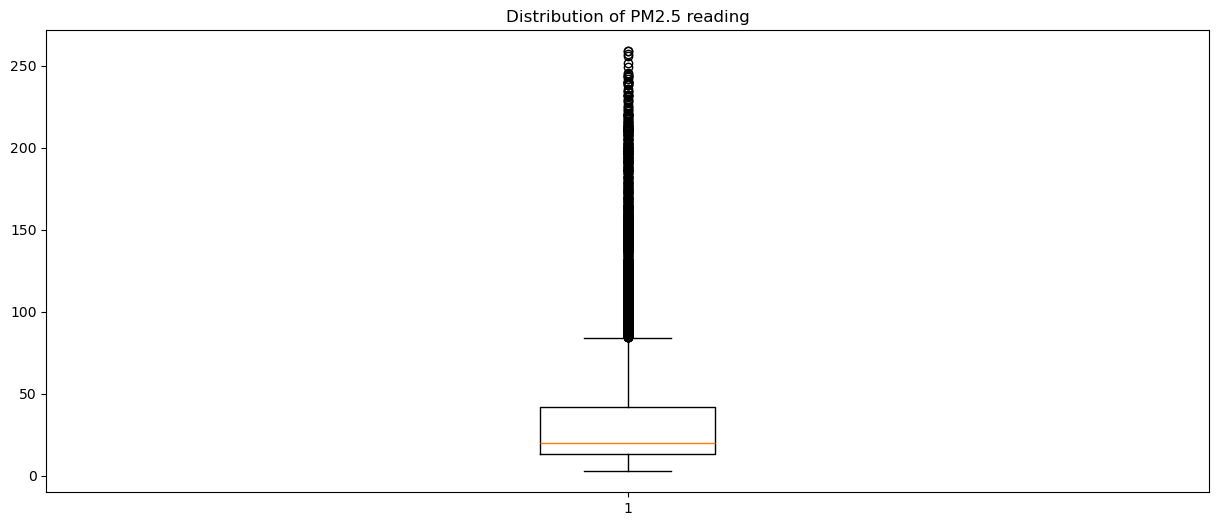

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
# .plot(kind="box", ax=ax)
ax.boxplot(df["PM2.5"])
ax.set_title("Distribution of PM2.5 reading");

Time Series plot

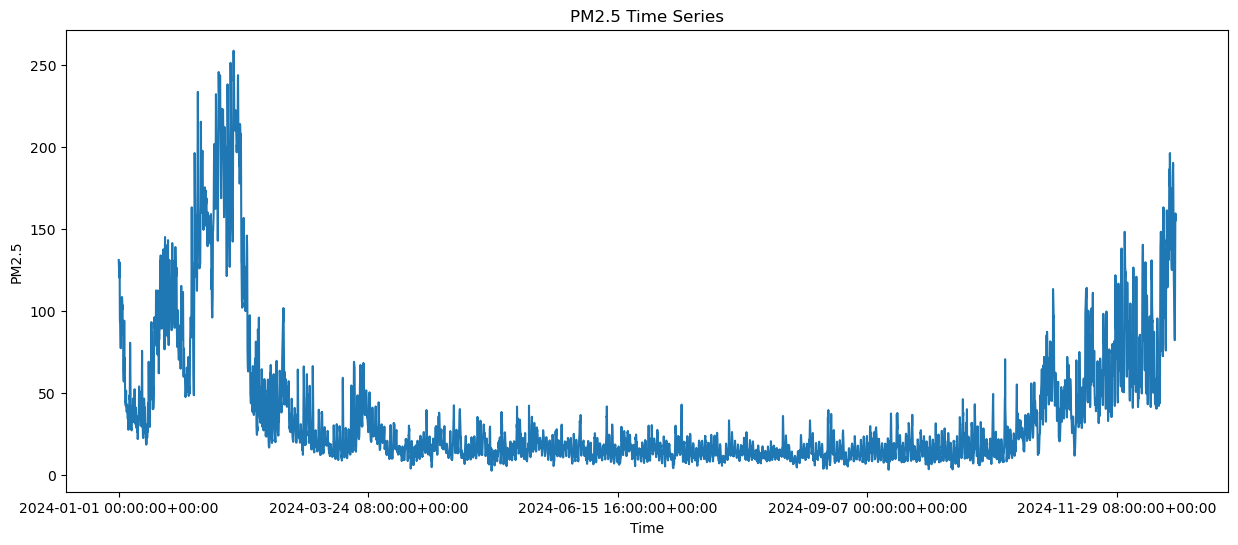

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))
df["PM2.5"].plot(xlabel="Time", ylabel="PM2.5", title="PM2.5 Time Series", ax=ax);

Let's plot a weekly average of PM2.5 Readings

<Axes: title={'center': 'PM2.5 Weekly Rolling Average'}, xlabel='Time', ylabel='PM2.5 Readings'>

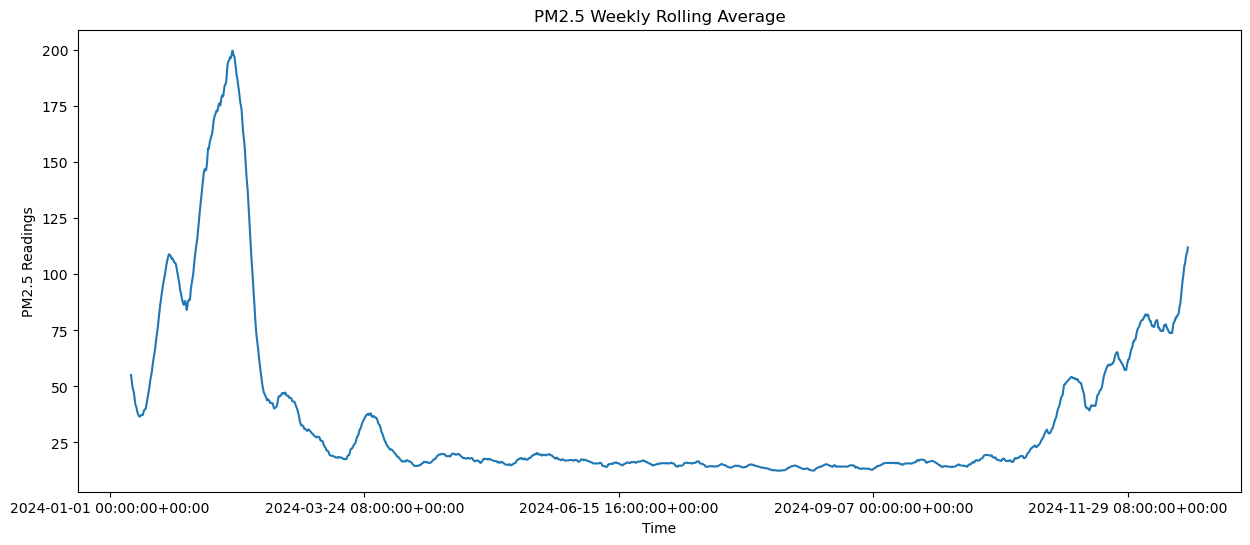

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))
df["PM2.5"].rolling(168).mean().plot(xlabel="Time", ylabel="PM2.5 Readings", title="PM2.5 Weekly Rolling Average")

### Correlation between PM 2.5 and PM 2.5 Lag 1

In [29]:
df.corr()

,PM2.5,PM2.5.L1
PM2.5,1.000000,0.992201
PM2.5.L1,0.992201,1.000000


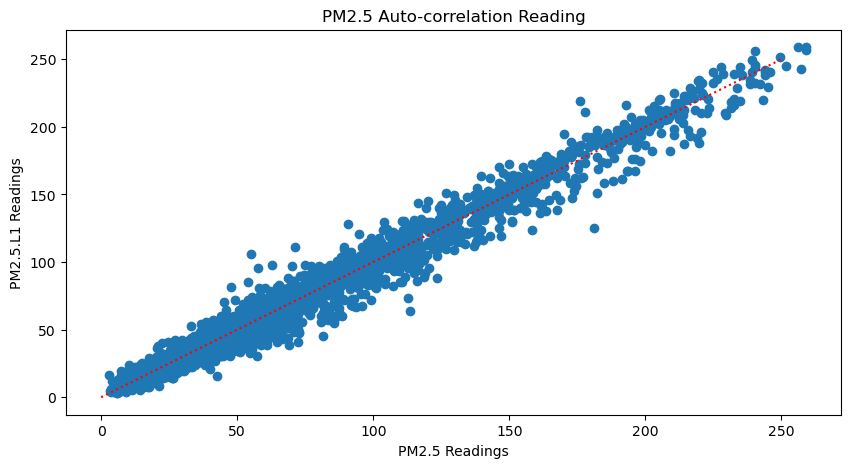

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(x=df["PM2.5"], y=df["PM2.5.L1"])
plt.plot([0, 250], [0, 250], linestyle="dotted", color="red")
plt.xlabel("PM2.5 Readings")
plt.ylabel("PM2.5.L1 Readings")
plt.title("PM2.5 Auto-correlation Reading");

### Split

Splitting the PM2.5 into Training and Test sets

In [31]:
target = "PM2.5"
y = df[target]
X = df.drop(columns=[target])

The training data is 80% of the dataset while the test data is the remaining 20%

In [32]:
cut_off = int(len(y) * 0.8)

y_train, y_test = y.iloc[:cut_off], y.iloc[cut_off:]
X_train, X_test = X.iloc[:cut_off], X.iloc[cut_off:]

### Baseline

Let's calculate the baseline mean absolute error for the model

In [33]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print(f"Mean PM2.5 reading: {y_mean.round(2)}")
print(f"Mean absolute error(MAE): {baseline_mae.round(2)}")

Mean PM2.5 reading: 33.7
Mean absolute error(MAE): 27.16


### Iterate

Let's instantiate LinearRegression model and fit it to the training data

In [34]:
model = LinearRegression()
model.fit(X=X_train, y=y_train)

LinearRegression()

### Evaluate

Let's calculate the training and test mean absolute error for the model

In [35]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print(f"Traning MAE: {training_mae.round(2)}")
print(f"Test MAE: {test_mae.round(2)}")

Traning MAE: 2.49
Test MAE: 4.95


### Communicate Results

Extracting feature coefficient and intercept from the model

In [36]:
intercept = round(model.intercept_, 2)
coefficient = round(model.coef_[0], 2)

print(f"PM2.5 = {intercept} + ({coefficient} * PM2.5.L1)")

PM2.5 = 0.17 + (0.99 * PM2.5.L1)


Let's see how well the model have performed by creating a DataFrame of `y_test` and `y_pred`

In [37]:
y_pred = model.predict(X_test)
df_pred_test = pd.DataFrame(
    {
        'y_test' : y_test,
        'y_pred' : y_pred
    }
)

df_pred_test

,y_test,y_pred
date,,
2024-10-09 08:00:00+00:00,22.700001,23.740500
2024-10-09 09:00:00+00:00,19.299999,22.746152
2024-10-09 10:00:00+00:00,16.900000,19.365368
2024-10-09 11:00:00+00:00,15.500000,16.978933
2024-10-09 12:00:00+00:00,10.400000,15.586846
...,...,...
2024-12-18 18:00:00+00:00,116.400002,93.941467
2024-12-18 19:00:00+00:00,140.199997,115.916555
2024-12-18 20:00:00+00:00,154.100006,139.582031


Let's create a time series plot for the values in `test_predictions` using plotly express

In [38]:
fig = px.line(df_pred_test, labels={"value" : "PM2.5"})
fig.show()